<a href="https://colab.research.google.com/github/cleitonmoya/MAE001_Trabalho2/blob/main/Trabalho2_vCleiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MAE001 - Projeto \#2 

MAE001 - Modelagem Matemática em Finanças I \\
Professor: Marco A. Cabral

Alunos:
* Cleiton Moya de Almeida
* Gustaco Maciel Ribeiro
* Renato Santana


## Introdução

O objetivo deste trabalho...

## Importação das Séries

In [473]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize

pd.reset_option('display.float_format')
#np.set_printoptions(precision=2)
#pd.options.display.precision = 2

In [474]:
# Séries financeiras
dir = 'https://raw.githubusercontent.com/cleitonmoya/MAE001_Trabalho2/main/series/'
series = ['IBOV', 'BBDC4', 'ITUB4', 'CSNA3', 'GGBR4', 'B3SA3',
                  'PETR4', 'MGLU3', 'ABEV3', 'WEGE3', 'VIVT4']
url = dir + 'IBOV' + '.csv'

# Cria primeiro um dataframe somente com o IBOV
df = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True, usecols=['Data', 'Fechamento'], header=0)
df.columns=['IBOV']

# Carrega as demais séries para o dataframe
for _,ativo in enumerate(series):
  url = dir + ativo + '.csv'
  df[ativo] = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True, usecols=['Data','Fechamento'])

# Ordena o dataframe por data crescente (a fim de permitir correta localização)
df.sort_index(inplace=True) 
df = df.loc['2015-01-01':'2019-12-31'] # período analisado

Visualização das séries importadas:

In [475]:
df

,IBOV,BBDC4,ITUB4,CSNA3,GGBR4,B3SA3,PETR4,MGLU3,ABEV3,WEGE3,VIVT4
Data,,,,,,,,,,,
2015-01-02,48512.22,13.01,13.81,4.21,8.40,7.88,8.79,0.22,13.95,10.82,31.81
2015-01-05,47516.82,13.04,13.88,4.05,8.04,7.65,8.08,0.23,13.64,10.76,31.68
2015-01-06,48000.92,13.46,14.11,4.32,8.94,7.72,7.82,0.22,14.04,10.59,31.40
2015-01-07,49462.91,14.00,14.62,4.79,9.61,8.05,8.14,0.23,14.38,10.58,31.98
2015-01-08,49943.30,14.07,14.85,4.68,9.43,7.97,8.62,0.23,14.43,10.71,32.31
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,115121.08,32.13,35.24,13.79,19.12,47.23,29.91,12.13,18.91,33.62,54.29
2019-12-23,115863.29,32.33,35.56,14.51,19.43,45.08,30.15,12.16,18.96,33.55,54.78
2019-12-26,117203.20,32.73,36.10,14.48,19.85,44.87,30.55,12.25,19.22,34.60,55.26


## Questão 1

Gera retornos (diários) aleatórios:

In [476]:
mu_min = 1e-3
mu_max = 5e-3
std_min = 1e-2
std_max = 3e-2

N = 7 # Número de ativos
seed = 39
# (5,42), (7, 39), (7, 37), 
T = 252 # período da série

# Gera série de retorno normal
def geraRetorno():
  mu = np.random.uniform(mu_min, mu_max)
  std = np.random.uniform(std_min, std_max)
  for t in range(T):
    R = np.random.normal(loc=mu, scale=std, size=T)
  return R

random.seed(seed)
np.random.seed(seed)
X = geraRetorno()
while (X.mean() < 0):
  X = geraRetorno()

dfX = pd.DataFrame(X.T, np.arange(1,T+1))
for n in range(1,N):
  X = geraRetorno()
  while (X.mean() < 0):
    X = geraRetorno()
  dfX[n] = X

# Nomeia os ativos (A, B, C...)
import string
ativos = list(string.ascii_uppercase)[:N]
dfX.rename(columns=dict(zip(range(N), ativos)), inplace=True)

Matriz de Covariância:

In [477]:
dfX.cov()

,A,B,C,D,E,F,G
A,0.000715,4.196135e-05,-0.000061,3.295252e-06,-0.000035,-8.932829e-06,0.000008
B,0.000042,8.070923e-04,-0.000038,-1.862042e-05,-0.000019,-7.374229e-07,-0.000025
C,-0.000061,-3.769579e-05,0.000731,3.568396e-05,0.000020,-1.484938e-05,0.000006
D,0.000003,-1.862042e-05,0.000036,5.177776e-04,-0.000017,1.439194e-07,0.000007
E,-0.000035,-1.935677e-05,0.000020,-1.707767e-05,0.000205,5.348935e-06,-0.000008
F,-0.000009,-7.374229e-07,-0.000015,1.439194e-07,0.000005,3.633081e-04,-0.000020
G,0.000008,-2.509877e-05,0.000006,7.195189e-06,-0.000008,-2.034396e-05,0.000111


In [478]:
if np.any(np.linalg.eigvals(dfX.cov().to_numpy()) == 0):
  print('Autovalor negativo!')
else: 
  print('Autovalores positivos!')

Autovalores positivos!


Índice Sharpe:

In [479]:
X_anual = (1+dfX.mean())**252-1   # retorno médio anualizado
Std_anual = dfX.std()*np.sqrt(252)
Var_anual = dfX.var()*252

dfS = pd.DataFrame(X_anual, columns=['Retorno'])
dfS['Risco_Std'] = Std_anual
dfS['Risco_Var'] = Var_anual
dfS['Sharpe'] = dfS.apply(lambda x: x['Retorno']/x['Risco_Std'],axis=1)
dfS

,Retorno,Risco_Std,Risco_Var,Sharpe
A,3.452899,0.424392,0.180108,8.136115
B,0.783570,0.450985,0.203387,1.737465
C,0.160401,0.429285,0.184286,0.373648
D,1.265659,0.361220,0.130480,3.503844
E,0.822865,0.227237,0.051637,3.621176
F,0.810801,0.302578,0.091554,2.679639
G,1.656917,0.167199,0.027955,9.909861


Simulação de carteiras:

In [480]:
N_por = 10000 # número de carteiras simuladas
Cov = dfX.cov().to_numpy()*252
R = dfS['Retorno'].to_numpy() 
np.random.seed(42)
X = np.array([])
Std = np.array([])
for n in range(N_por):
  P = np.random.dirichlet(np.ones(N))
  X = np.append(X, R@P)                         # Retorno das carteiras
  Std = np.append(Std, np.sqrt(P.T@Cov@P))      # Risco (Std) das carteiras
S = X/Std # Índice Sharpe das Carteiras

Bala de Markowitz:

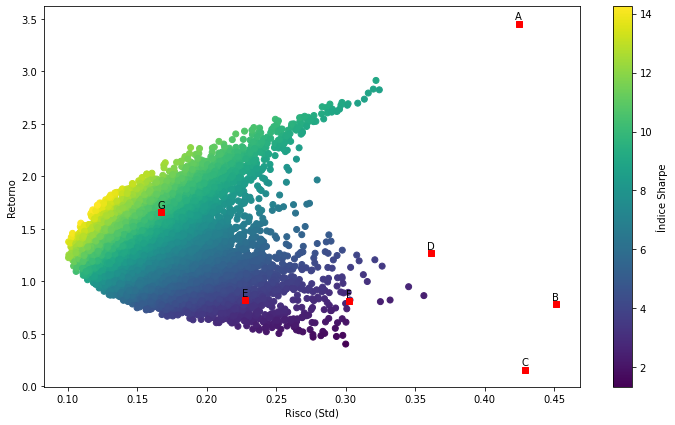

In [481]:
# Plota as carteiras simuladas
plt.figure(figsize=(12,7))
plt.xlabel('Risco (Std)')
plt.ylabel('Retorno')  
plt.scatter(Std, X, c=S, cmap='viridis')
plt.colorbar(label='Índice Sharpe')

# Plota as carteiras mono-ativo
plt.scatter(dfS.Risco_Std, dfS.Retorno, marker='s', color='r')
for label, x, y in zip(ativos, dfS['Risco_Std'], dfS['Retorno']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 2),
        textcoords='offset points', ha='center', va='bottom')
plt.show()

## Questão 2

* Setor Financeiro:
   * Banco Bradesco (BBDC4);
   * Banco Itaú-Unibanco (ITUB4);
* Setor de Siderurgia:
   * Companhia Siderúrigica Nacional (CSNA3)
   * Grupo Gerdau (GGBR4)
 


Cálculo do retorno percentual:

In [482]:
df_ret = df.pct_change().iloc[1:,:] # matriz de retornos
df_ret.describe()

,IBOV,BBDC4,ITUB4,CSNA3,GGBR4,B3SA3,PETR4,MGLU3,ABEV3,WEGE3,VIVT4
count,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,0.000801,0.000950,0.000952,0.001758,0.001159,0.001559,0.001498,0.004519,0.000330,0.001097,0.000555
std,0.013874,0.020328,0.018906,0.039653,0.030308,0.020734,0.031537,0.051162,0.013704,0.017776,0.015506
min,-0.087995,-0.131455,-0.120421,-0.204494,-0.120000,-0.084682,-0.157572,-0.250000,-0.082579,-0.090379,-0.068994
25%,-0.007190,-0.011067,-0.009709,-0.022444,-0.017078,-0.010855,-0.015707,-0.009852,-0.007246,-0.009743,-0.008045
50%,0.000905,0.000969,0.000842,0.000000,0.000000,0.000671,0.001471,0.000000,0.000000,0.000602,0.000000
75%,0.008960,0.012587,0.011254,0.022866,0.018458,0.013675,0.017241,0.019231,0.007786,0.012116,0.009434
max,0.065958,0.130034,0.109179,0.206675,0.161880,0.101351,0.161959,0.375000,0.085373,0.071639,0.143594


Análise de correlação das ações com o IBOV:

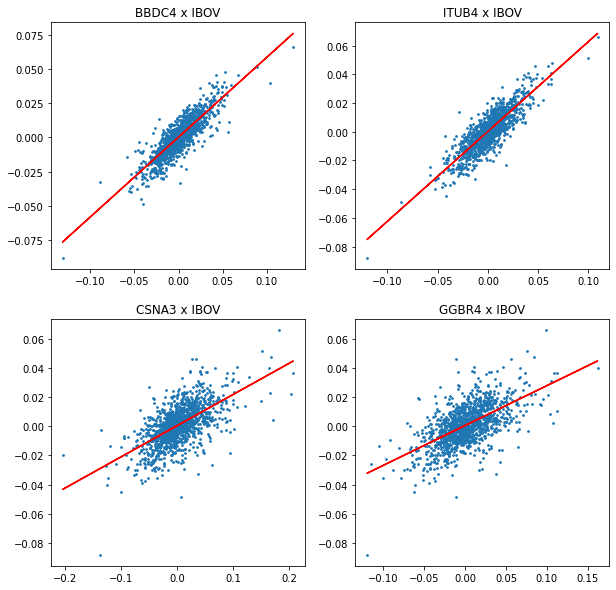

In [483]:
from scipy.stats import linregress
df_ret = df.pct_change().iloc[1:,:] # matriz de retornos

fig, axs = plt.subplots(2, 2,figsize=(10,10))
y = df_ret.IBOV
x = df_ret.BBDC4
axs[0,0].set_title('BBDC4 x IBOV')
axs[0,0].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[0,0].plot(x, m*x+b, c='r')

x = df_ret.ITUB4
axs[0,1].set_title('ITUB4 x IBOV')
axs[0,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[0,1].plot(x, m*x+b, c='r')

x = df_ret.CSNA3
axs[1,0].set_title('CSNA3 x IBOV')
axs[1,0].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[1,0].plot(x, m*x+b, c='r')

x = df_ret.GGBR4
axs[1,1].set_title('GGBR4 x IBOV')
axs[1,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[1,1].plot(x, m*x+b, c='r')

plt.show()

Podemos observar que BBDC4 e ITUB possuem forte correlação com o IBOV.

Ativos ativos do mesmo setor:

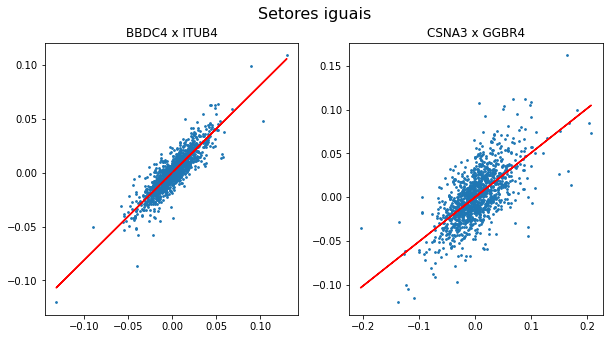

In [484]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Setores iguais', fontsize=16)
axs[0].set_title('BBDC4 x ITUB4')
x = df_ret.BBDC4
y = df_ret.ITUB4
axs[0].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[0].plot(x, m*x+b, c='r')


axs[1].set_title('CSNA3 x GGBR4')
x = df_ret.CSNA3
y = df_ret.GGBR4
axs[1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[1].plot(x, m*x+b, c='r')
plt.show()

Podemos observar que BBDC4 e ITUB4 possum forte correlação positiva, enquanto que CSNA3 e GGBR4 possuem correlação menor.

Ações de setores diferentes:

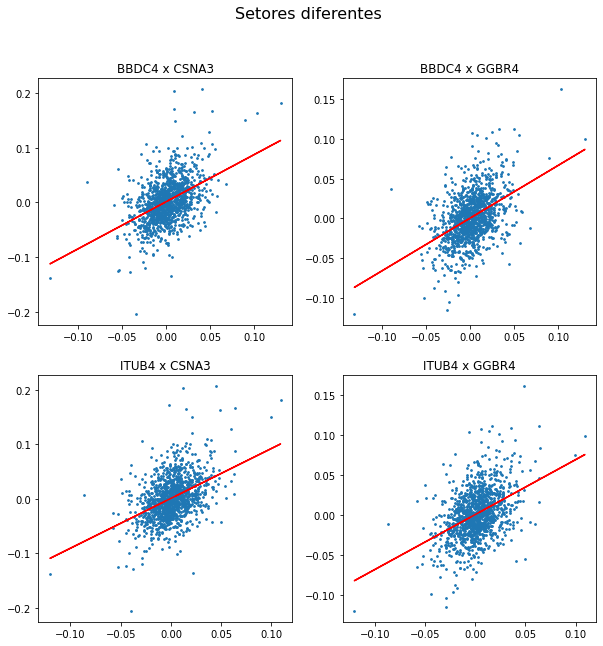

In [485]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Setores diferentes', fontsize=16)
axs[0,0].set_title('BBDC4 x CSNA3')
x = df_ret.BBDC4
y = df_ret.CSNA3
axs[0,0].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[0,0].plot(x, m*x+b, c='r')

axs[0,1].set_title('BBDC4 x GGBR4')
y = df_ret.GGBR4
axs[0,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[0,1].plot(x, m*x+b, c='r')

axs[1,0].set_title('ITUB4 x CSNA3')
x = df_ret.ITUB4
y = df_ret.CSNA3
axs[1,0].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[1,0].plot(x, m*x+b, c='r')

axs[1,1].set_title('ITUB4 x GGBR4')
y = df_ret.GGBR4
axs[1,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
axs[1,1].plot(x, m*x+b, c='r')
plt.show()

Podemos melhor visualizar através da matriz de correlação plotada na forma de um mapa de calor:

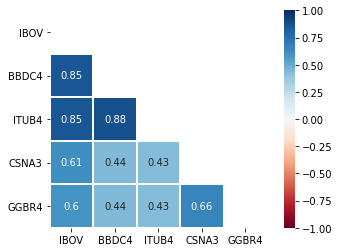

In [486]:
M_Cor = df_ret.iloc[:,:5].corr()
mask = np.triu(np.ones_like(M_Cor, dtype=bool)) # Generate a mask for the upper triangle
ax = sns.heatmap(M_Cor, mask=mask, vmin=-1, vmax=+1, cmap='RdBu', linewidths=1, annot=True, square=True)
plt.yticks(rotation=0) 
plt.show()

## Questão 3

Ativos escolhidos:
* BBDC4 - Bradesco
* ITUB4 - Itaú-Unibanco
* CSNA3 - CSN
* GGBR4 - Grupo Gerdau
* B3SA3 - B3
* PETR4 - Petrobras
* MGLU3 - Magazine Luíza
* ABEV3 - Ambev
* WEGE3 - WEG
* VIVT4 - Vivo

Índice Sharpe dos ativos:

In [487]:
df_X = df.pct_change().iloc[1:,1:] # matriz de retornos diários

X_anual = (1+df_X.mean())**252-1   # retorno médio anualizado
Std_anual = df_X.std()*np.sqrt(252)
Var_anual = df_X.var()*252

df_S = pd.DataFrame(X_anual, columns=['Retorno'])
df_S['Risco_Std'] = Std_anual
df_S['Risco_Var'] = Var_anual
df_S['Sharpe'] = df_S.apply(lambda x: x['Retorno']/x['Risco_Std'],axis=1)
df_S

,Retorno,Risco_Std,Risco_Var,Sharpe
BBDC4,0.270465,0.322694,0.104132,0.838146
ITUB4,0.270828,0.300126,0.090076,0.902381
CSNA3,0.556750,0.629473,0.396236,0.884470
GGBR4,0.338852,0.481128,0.231484,0.704287
B3SA3,0.480767,0.329147,0.108338,1.460645
PETR4,0.458035,0.500630,0.250630,0.914917
MGLU3,2.114900,0.812171,0.659622,2.604009
ABEV3,0.086756,0.217543,0.047325,0.398796
WEGE3,0.318107,0.282180,0.079626,1.127318
VIVT4,0.150009,0.246149,0.060589,0.609423


Matriz de covariância:

In [488]:
df_X.cov()*252

,BBDC4,ITUB4,CSNA3,GGBR4,B3SA3,PETR4,MGLU3,ABEV3,WEGE3,VIVT4
BBDC4,0.104132,0.084758,0.089935,0.068954,0.066696,0.095763,0.063717,0.027283,0.036305,0.037576
ITUB4,0.084758,0.090076,0.082152,0.062117,0.061326,0.087118,0.056117,0.026463,0.035014,0.033763
CSNA3,0.089935,0.082152,0.396236,0.200662,0.081102,0.154587,0.097624,0.037043,0.038434,0.043563
GGBR4,0.068954,0.062117,0.200662,0.231484,0.057298,0.109034,0.067180,0.027480,0.035424,0.033369
B3SA3,0.066696,0.061326,0.081102,0.057298,0.108338,0.086412,0.055593,0.026964,0.031878,0.031052
PETR4,0.095763,0.087118,0.154587,0.109034,0.086412,0.250630,0.085291,0.031411,0.039996,0.047232
MGLU3,0.063717,0.056117,0.097624,0.067180,0.055593,0.085291,0.659622,0.028932,0.045500,0.031245
ABEV3,0.027283,0.026463,0.037043,0.027480,0.026964,0.031411,0.028932,0.047325,0.020018,0.017493
WEGE3,0.036305,0.035014,0.038434,0.035424,0.031878,0.039996,0.045500,0.020018,0.079626,0.021343
VIVT4,0.037576,0.033763,0.043563,0.033369,0.031052,0.047232,0.031245,0.017493,0.021343,0.060589


Matriz de correlação:

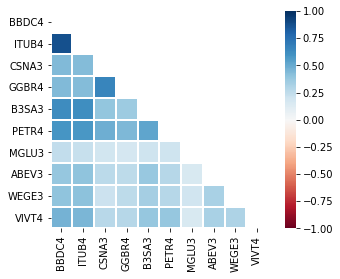

In [489]:
Cor = df_X.corr()
mask = np.triu(np.ones_like(Cor, dtype=bool)) # Generate a mask for the upper triangle
ax = sns.heatmap(Cor, mask=mask, vmin=-1, vmax=+1, cmap='RdBu', linewidths=1, square=True) 
plt.show()

### Carteira ótima

In [490]:
# Retorno esperado
def ret_esp(p):
  ret = R @ p
  return ret

def risco_esp(p):
  risco = np.sqrt(p.T @ Cov @ p)
  return risco

def neg_sharpe(p):
    ret = R @ p
    risco = np.sqrt(p.T @ Cov @ p)
    return -1*ret/risco### Carteira Ótima

Cov = df_X.cov().to_numpy()*252         # Matriz de covariância dos retornos anualizados
R = df_S['Retorno'].to_numpy()          # Retorno médio de cada ativo carteira

# Restrições da otimização
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1),
          (0,1), (0,1), (0,1), (0,1), (0,1))
cons = ({'type':'eq', 'fun': lambda p: p.sum()-1})

p0 = [0.10]*10
result = minimize(neg_sharpe, p0, method='SLSQP', bounds=bounds, constraints=cons)
p_otm = result['x']
pd.DataFrame(p_otm.round(2), series[1:], columns=['%'])

,%
BBDC4,0.00
ITUB4,0.00
CSNA3,0.01
GGBR4,0.00
B3SA3,0.37
PETR4,0.00
MGLU3,0.43
ABEV3,0.00
WEGE3,0.19
VIVT4,0.00


In [491]:
p_otm_ret = R@p_otm
p_otm_std = np.sqrt(p_otm.T@Cov@p_otm)
print('Retorno:', p_otm_ret)
print('Risco:', p_otm_std)

Retorno: 1.1481172338880525
Risco: 0.41153852830411874


### Carteira de variância mínima

In [492]:
cons = ({'type':'eq', 'fun': lambda p: p.sum()-1})
result = minimize(risco_esp, p0, method='SLSQP', bounds=bounds, constraints=cons)
p_min = result['x']
pd.DataFrame(p_min.round(2), series[1:], columns=['%'])

,%
BBDC4,0.00
ITUB4,0.01
CSNA3,0.00
GGBR4,0.00
B3SA3,0.03
PETR4,0.00
MGLU3,0.00
ABEV3,0.46
WEGE3,0.19
VIVT4,0.31


In [493]:
p_min_ret = R@p_min
p_min_std = np.sqrt(p_min.T@Cov@p_min)
print('Retorno:', p_min_ret)
print('Risco:', p_min_std)

Retorno: 0.16450584267471738
Risco: 0.1792400346475971


### Fronteira Eficiente

In [494]:
carteiras_otm = []
ef_x = np.array([])
ef_y = np.linspace(p_min_ret, df_S.Retorno.max(),200)

# Minimização do risco
for ret in ef_y:
    cons = ({'type':'eq', 'fun': lambda p: p.sum()-1},
            {'type':'eq', 'fun': lambda p: ret_esp(p) - ret})
    
    # minimiza o risco para cada retorno
    result = minimize(risco_esp, p0, method='SLSQP', 
                      bounds=bounds, constraints=cons)
    
    ef_x = np.append(ef_x, result['fun'])
    carteiras_otm.append(result['x'])
carteiras_otm = np.array(carteiras_otm)

### Fronteira não-eficiente

In [495]:
nef_x = np.array([])
nef_y = np.linspace(df_S.Retorno.min(), p_min_ret, 200)
# Minimização do risco
for ret in nef_y:
    cons = ({'type':'eq', 'fun': lambda p: p.sum()-1},
            {'type':'eq', 'fun': lambda p: ret_esp(p) - ret})
    
    # minimiza o risco para cada retorno
    result = minimize(risco_esp, p0, method='SLSQP', 
                      bounds=bounds, constraints=cons)
    
    nef_x = np.append(nef_x, result['fun'])

### Bala de Markowitz

Simulação de carteiras:

In [496]:
N_por = 100000 # número de carteiras simuladas
np.random.seed(42)
X = np.array([])
Std = np.array([])
for n in range(N_por):
  P = np.random.dirichlet(np.ones(10))
  P =P/P.sum()
  X = np.append(X, R@P)                         # Retorno das carteiras
  Std = np.append(Std, np.sqrt(P.T@Cov@P))      # Risco (Std) das carteiras
S = X/Std # Índice Sharpe das Carteiras

Plota a Bala de Markowitz e as fronteiras:

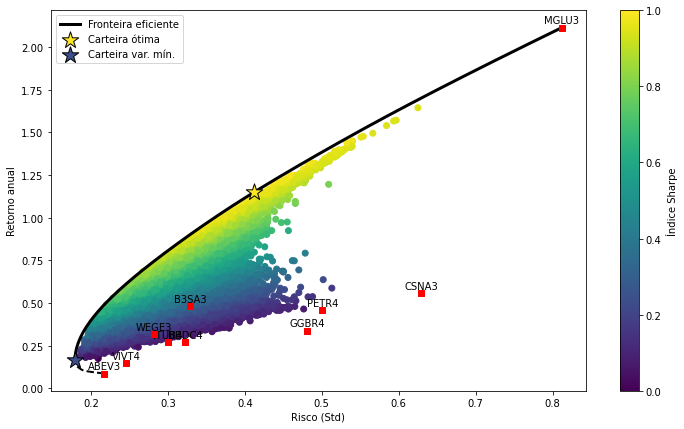

In [497]:
# Plota as carteiras simuladas
plt.figure(figsize=(12,7))
plt.xlabel('Risco (Std)')
plt.ylabel('Retorno anual')  
plt.scatter(Std, X, c=S, cmap='viridis')

# Plota a Fronteira Eficiente
plt.plot(ef_x,ef_y, 'k', linewidth=3, label='Fronteira eficiente')

# Plota fronteira não eficiente
plt.plot(nef_x,nef_y, 'k--', linewidth=2)

# Plota as carteiras mono-ativo
plt.scatter(df_S.Risco_Std, df_S.Retorno, marker='s', color='r', zorder=9)
plt.colorbar(label='Índice Sharpe')
for label, x, y in zip(series[1:], df_S['Risco_Std'], df_S['Retorno']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 2),
        textcoords='offset points', ha='center', va='bottom')

# Plota a carteira ótima e de variância mínima
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap 
normalize = Normalize(vmin=df_S.Sharpe.min(), vmax=df_S.Sharpe.max())
cmap = get_cmap('viridis')
cor_otm = cmap(normalize(p_otm_ret/p_otm_std))
cor_min = cmap(normalize(p_min_ret/p_min_std))

plt.scatter(p_otm_std, p_otm_ret, marker='*', color=cor_otm, edgecolors='k',
            cmap='viridis', s=300, label='Carteira ótima', zorder=10)

plt.scatter(p_min_std, p_min_ret, marker='*', color=cor_min, edgecolors='k',
            cmap='viridis', s=300, label='Carteira var. mín.', zorder=10)

plt.legend()
plt.show()

### Carteiras na Fronteira Eficiente 

Para verificar o efeito de concentração de ativos nas carteiras da fronteira efeiciente computamos, para cada valor de risco $R$, o percentual $\pi_i(R)$ de participação dos "top 5" ativos (os 5 ativos com maior peso na carteira).

In [498]:
df_carteiras_ef = pd.DataFrame(carteiras_otm, ef_x, columns=series[1:])
C = np.array([])
for k,_ in enumerate(ef_x):
  c = df_carteiras_ef.iloc[k].sort_values(ascending=False)[:5].sum()
  C = np.append(C,c)
df_carteiras_ef['Top 5'] = C
df_carteiras_ef

,BBDC4,ITUB4,CSNA3,GGBR4,B3SA3,PETR4,MGLU3,ABEV3,WEGE3,VIVT4,Top 5
0.179241,0.000000e+00,1.148272e-02,0.000000e+00,0.000000e+00,3.132403e-02,3.860355e-17,6.622977e-18,4.593029e-01,1.891840e-01,3.087063e-01,1.000000
0.179316,2.249985e-18,8.776811e-03,0.000000e+00,1.947240e-04,4.007650e-02,1.182930e-17,3.176702e-03,4.509461e-01,1.917166e-01,3.051126e-01,0.996629
0.179467,4.662826e-18,6.021962e-03,2.692427e-17,2.719063e-04,4.544327e-02,0.000000e+00,7.181148e-03,4.452320e-01,1.923971e-01,3.034526e-01,0.993706
0.179691,8.502800e-18,5.196638e-03,0.000000e+00,1.314902e-04,5.019346e-02,0.000000e+00,1.123782e-02,4.399472e-01,1.926996e-01,3.005938e-01,0.994672
0.179986,0.000000e+00,2.281034e-03,2.542949e-17,6.515740e-04,5.438750e-02,0.000000e+00,1.535353e-02,4.349658e-01,1.942808e-01,2.980797e-01,0.997067
...,...,...,...,...,...,...,...,...,...,...,...
0.794366,2.775558e-17,1.804112e-16,0.000000e+00,5.551115e-17,2.399063e-02,0.000000e+00,9.760094e-01,6.938894e-17,1.387779e-17,1.387779e-17,1.000000
0.798810,0.000000e+00,0.000000e+00,2.775558e-17,5.551115e-17,1.799297e-02,0.000000e+00,9.820070e-01,0.000000e+00,0.000000e+00,2.775558e-17,1.000000
0.803259,0.000000e+00,0.000000e+00,5.551115e-17,1.387779e-17,1.199531e-02,5.551115e-17,9.880047e-01,0.000000e+00,2.775558e-17,0.000000e+00,1.000000
0.807713,0.000000e+00,4.163336e-17,9.714451e-17,0.000000e+00,5.997655e-03,0.000000e+00,9.940023e-01,6.938894e-17,6.938894e-17,1.387779e-17,1.000000


Plotamos então participação de ativos na carteira, bem como a participação dos **top 5** ao longo da fronteira efieciente:

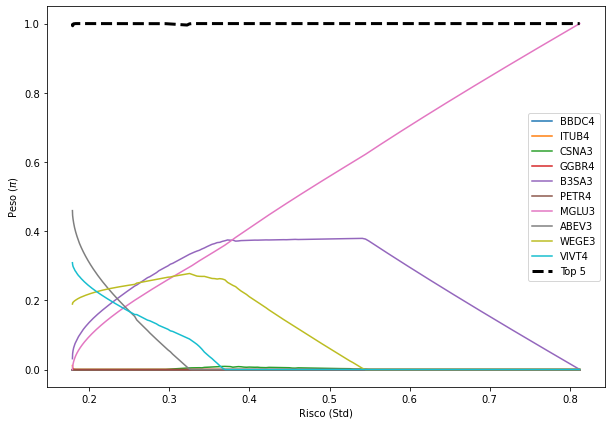

In [499]:
fig,ax = plt.subplots(figsize=(10,7))
for k,s in enumerate(df_carteiras_ef.columns.to_list()):
  if k == 10:
    ax.plot(df_carteiras_ef[s], 'k--', linewidth=3, label=s)
  else:
    ax.plot(df_carteiras_ef[s],label=s)
ax.set_xlabel('Risco (Std)')
ax.set_ylabel('Peso ($\pi$)')
ax.legend()
plt.show()

Podemos visualizar que ocorre concentração dos ativos nas carteiras da fronteira eficiente.

## Questão 4

### a) Retornos Diários

Escolhemos analisar ativo **B3SA3** no período de 01-01-2015 a 31-12-2019.

In [500]:
dfD = df_ret.B3SA3.copy()
dfD

Data
2015-01-05   -0.029188
2015-01-06    0.009150
2015-01-07    0.042746
2015-01-08   -0.009938
2015-01-09   -0.021330
                ...   
2019-12-20    0.011133
2019-12-23   -0.045522
2019-12-26   -0.004658
2019-12-27   -0.052374
2019-12-30   -0.027987
Name: B3SA3, Length: 1233, dtype: float64

Em uma visualização prelininar dos dados, observamos que, aparentemente, a distribuição normal se ajusta bem aos dados:

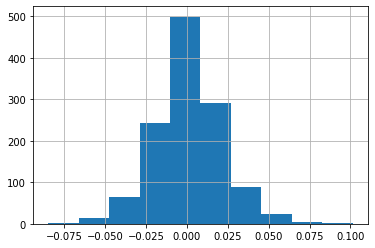

In [501]:
ax = dfD.hist()

Podemos estimar o VaR com vários níveis de confiança de dois modos:
* Método histórico: utiliza o histograma dos dados históricos;
* Método da variância: utiliza a uma distribuição normal estimada à partir da média e variância dos dados históricos.


#### Histograma e distribuição estimada

In [502]:
# Funções auxiliares - arredondamento para cima e para baixo
import math
def round_down(number:float, decimals:int=2):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)
    factor = 10 ** decimals
    return math.floor(number * factor) / factor

def round_up(number:float, decimals:int=2):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

A figura abaixo mostra o histograma dos retornos e a distribuição estimada.

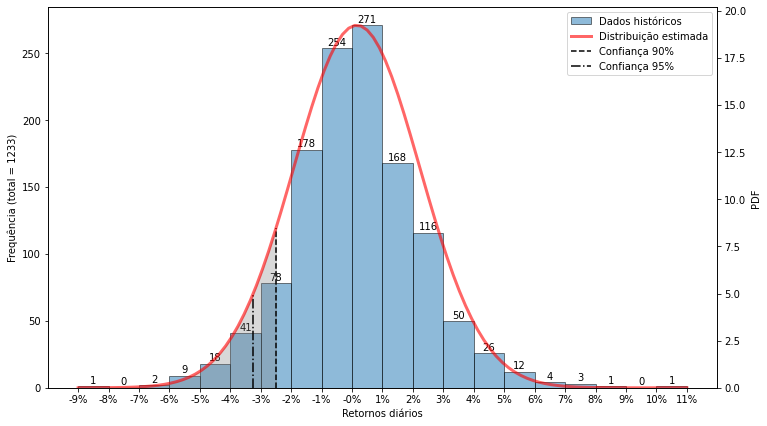

In [503]:
# Cálculo dos parâmetros
r_min = round_down(dfD.min(),2)
r_max = round_up(dfD.max(),2)
r_mean = dfD.mean()
r_std = dfD.std()

x = np.arange(r_min, r_max+0.01, 0.01)
fig, ax = plt.subplots(figsize=(12,7))

# Histograma
count = ax.hist(dfD, bins=x, edgecolor='k', alpha=0.5, label='Dados históricos')[0]

# Distribuição normal (PDF)
from scipy.stats import norm
y_nor = norm.pdf(np.linspace(r_min, r_max, 100), loc=r_mean, scale=r_std)

ax2 = ax.twinx()
ax2.plot(np.linspace(r_min, r_max, 100),y_nor, c='r', alpha=0.6, linewidth='3', label='Distribuição estimada')
ax2.set_ylim(bottom=0)


# Calcula
x90 = norm.ppf(0.10, loc=r_mean, scale=r_std)
y90 = norm.pdf(x90, loc=r_mean, scale=r_std)
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
y95 = norm.pdf(x95, loc=r_mean, scale=r_std)

x_area90 = np.linspace(r_min, x90)
y_area90 = norm.pdf(x_area90, loc=r_mean, scale=r_std)
ax2.fill_between(x_area90, y_area90, color='grey', alpha=0.3)

ax2.vlines(x90, 0, y90, linestyle='--', label='Confiança 90%')
ax2.vlines(x95, 0, y95, linestyle='-.', label='Confiança 95%')

for k,p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+2,
            # '{:.0%}'.format(1-count[:k].sum()/len(dfD)),
            '{:.0f}'.format(height),
            ha="center") 
 
import matplotlib.ticker as mtick
ax.set_xticks(x)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel('Retornos diários')
ax.set_ylabel('Frequência (total = {})'.format(len(dfD)))

ax2.set_ylabel('PDF')

# Legenda
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax.legend(lines, labels, loc=0)
plt.show()

#### Método Histórico

Para calcularmos o VaR à partir do histograma (dados históricos), contamos o número de retornos observados no intervalo desejado e então dividimos pelo número total de retornos em todo período observados.

Por exemplo, no intervalo  $[-3, -2)\%$ temos $78$ retornos observados de um total de $1233$. Então, a probabilidade do intervalo é $78\div1233 = 0,57\%$. Logo, o $VaR$ é $0,57 \% \times R\$10.000,00 = \$57,00$ com um  nível de confiança de $99,4\%$.

Calculando a probabilidade para o intervalo $( \infty, -4]\%$, a partir do histograma:

In [504]:
bin = 4 #(começando de 0)
f4 = count[:bin+1].sum()
p4 = f4/len(dfD)
M = 10000
print('Probabilidade:', p4)
print('1-P:', 1-p4)
print('VaR:', 0.04*M)

Probabilidade: 0.024330900243309004
1-P: 0.975669099756691
VaR: 400.0


Para o intervalo $( \infty, -3]\%$:

In [505]:
bin = 5 #(começando de 0)
f3 = count[:bin+1].sum()
p3 = f3/len(dfD)
M = 10000
print('Probabilidade:', p3)
print('1-P:', 1-p3)
print('VaR:', 0.03*M)

Probabilidade: 0.0575831305758313
1-P: 0.9424168694241687
VaR: 300.0


Para o intervalo $( \infty, -2]\%$:

In [506]:
bin = 6
f2 = count[:bin+1].sum()
p2 = f2/len(dfD)
print('Probabilidade:', p2)
print('1-P:', 1-p2)
print('VaR:', 0.02*M)

Probabilidade: 0.12084347120843471
1-P: 0.8791565287915653
VaR: 200.0


Assim, pelo histograma, estimamos:
* Para um nível de confiança de $90\%$: $ R\$ 200,00 \leq VaR < R\$ 300,00$ (perdas entre 2 e 3%).  \\
* Para um nível de confiança de $95\%$: $ R\$ 300,00 \leq VaR < R\$ 400,00$ (perdas entre 3 e 4%). 

Notamos que, pelo método histórico (usando histograma), o VaR é estimado somente como um intervalo, devido aos bins do histograma.

Uma alternativa para melhorar a estimativa (diminuir o intervalo) seria aumentar o número de bins do histrograma. Porém, ainda estaríamos trabahando com um um intervalo. 

Uma outra alternativa, mais precisa, é contarmos cada retorno diferente obervado na série e então construirmos uma ***distribuição cumulativa empírica***. A partir desta distribuição, fica fácil visualizar qual o nível de probabilidade acumulada ($\alpha$) para cada perda máxima e, a partir dos dados históricos, estimar o VaR para um dado nível de confiança($1-\alpha$).  

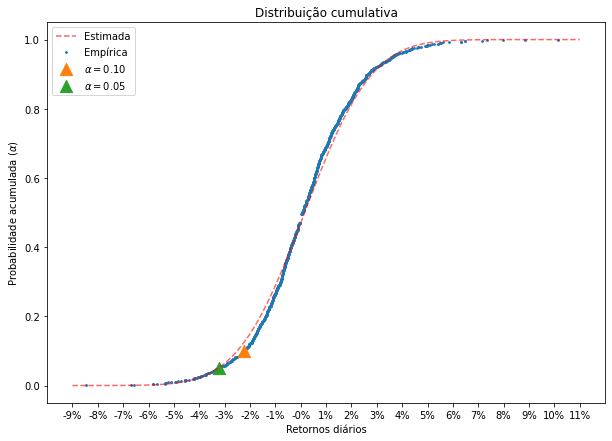

In [507]:
fig,ax = plt.subplots(figsize=(10,7))
ax.set_title('Distribuição cumulativa')

# distribuição empírica
x,f = np.unique(dfD, return_counts=True)
cdf = f.cumsum()/f.sum()
ax.scatter(x,cdf, s=3, label='Empírica')

# distribuição estimada
y_nor = norm.cdf(np.linspace(r_min, r_max, 100), loc=r_mean, scale=r_std)
ax.plot(np.linspace(r_min, r_max, 100),y_nor, 'r--', alpha=0.6, label='Estimada')

# perda máxima para confiança de 90%
alpha = 0.1
pos90 = np.argwhere(cdf>=alpha)[0][0]
x90 = x[pos90]
ax.scatter(x90, alpha, s=150, marker='^', label=r'$ \alpha=0.10$')


# perda máxima para confiança de 95%
alpha = 0.05
pos95 = np.argwhere(cdf>=alpha)[0][0]
x95 = x[pos95]
ax.scatter(x95, alpha, s=150, marker='^', label=r'$ \alpha=0.05$')
ax.set_xticks(np.arange(r_min, r_max+0.01, 0.01))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

ax.set_xlabel('Retornos diários')
ax.set_ylabel(r'Probabilidade acumulada ($\alpha$)')
ax.legend()
plt.show()

Com $90\%$ de confiança:

In [508]:
print('VaR: R$ {:.2f}'.format(-x90*M))

VaR: R$ 224.72


Com $95\%$ de confiança:

In [509]:
print('VaR: R$ {:.2f}'.format(-x95*M))

VaR: R$ 323.28


#### Método da Variância

O método da variância estimativa o VaR com base em distribuição normal ajustada com parâmetros $N(\mu, \sigma)$, onde $\mu$ é a média dos retornos e $\sigma$ o desvio padrão amostral. 

Para computarmos a perda máxima % para um dado nível de significância $\alpha$ (confiança igual a $1-\alpha$), utilizamos a função distribuição cumulativa inversa, a qual permite para qual valor da variável aleatória a probabilidade acumulada é $\alpha$.

In [510]:
x90 = norm.ppf(0.10, loc=r_mean, scale=r_std)
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
print('Perda máxima - confiança de 90%: {:.2%}'.format(x90))
print('Perda máxima - confiança de 95%: {:.2%}'.format(x95))

Perda máxima - confiança de 90%: -2.50%
Perda máxima - confiança de 95%: -3.25%


Assim, computamos o VaR:

In [511]:
VaR90 = -x90*M
VaR95 = -x95*M
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
print('VaR - confiança de 90%: R$ {:.2f}'.format(VaR90))
print('VaR - confiança de 95%: R$ {:.2f}'.format(VaR95))

VaR - confiança de 90%: R$ 250.13
VaR - confiança de 95%: R$ 325.46


Observamos que o valor do VaR com confiança de $90\%$ difere em $R\$ 25,41$ da estimativa gerada com a distribuição empírica. Já a estimativa para o nível de confiança de $95\%$ pouco diferem.

### b) Retornos quizenais

Carregando a série de preços quinzenais e calculado a série de retornos:

In [512]:
# Séries financeiras
dir = 'https://raw.githubusercontent.com/cleitonmoya/MAE001_Trabalho2/main/series/'
url = dir + 'B3SA3_Q' + '.csv'
dfQ = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True, usecols=['Data', 'Fechamento'], header=0)
dfQ.columns=['B3SA3']

# Ordena o dataframe por data crescente (a fim de permitir correta localização)
dfQ.sort_index(inplace=True) 
dfQ = dfQ.loc['2015-01-01':'2019-12-31'] # período analisado
dfQ = dfQ.pct_change().iloc[1:,:]['B3SA3'] # matriz de retornos

Em uma visualização preliminar dos dados, observamos que a série visivelmente não se ajusta bem a uma distriuição normal. Observamos também a presença de um retorno do tipo *outlier* cima de $40\%$.

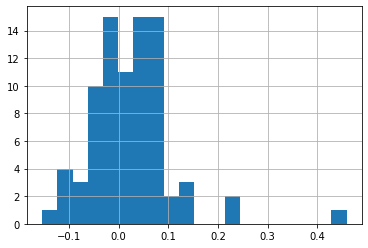

In [513]:
ax = dfQ.hist(bins=20)

Sem prejuízo para as estimativas das perdas pelo método histórico, a fim de tentarmos obter um melhor modelo para o Método da Variância, removemos este *outlier* da série:

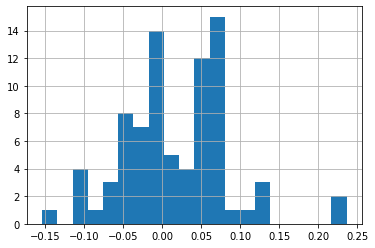

In [514]:
from scipy.stats import zscore
z_scores = zscore(dfQ)
filtered_entries = (z_scores <= 3)
new_df = dfQ[filtered_entries]
dfQ = new_df.copy()
ax = dfQ.hist(bins=20)

#### Histograma e distribuição estimada

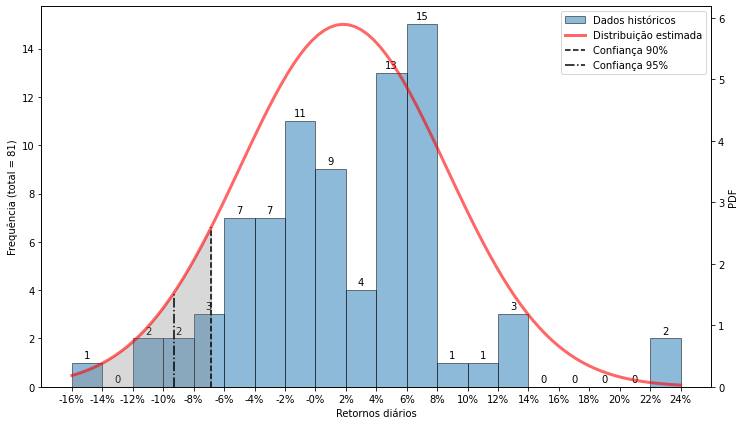

In [515]:
# Cálculo dos parâmetros
r_min = round_down(dfQ.min(),2)
r_max = round_up(dfQ.max(),2)
r_mean = dfQ.mean()
r_std = dfQ.std()

x = np.arange(r_min, r_max+0.02, 0.02)
fig, ax = plt.subplots(figsize=(12,7))

# Histograma
count = ax.hist(dfQ, bins=x, edgecolor='k', alpha=0.5, label='Dados históricos')[0]

# Distribuição normal (PDF)
from scipy.stats import norm
y_nor = norm.pdf(np.linspace(r_min, r_max, 100), loc=r_mean, scale=r_std)

ax2 = ax.twinx()
ax2.plot(np.linspace(r_min, r_max, 100),y_nor, c='r', alpha=0.6, linewidth='3', label='Distribuição estimada')
ax2.set_ylim(bottom=0)

# Calcula
x90 = norm.ppf(0.10, loc=r_mean, scale=r_std)
y90 = norm.pdf(x90, loc=r_mean, scale=r_std)
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
y95 = norm.pdf(x95, loc=r_mean, scale=r_std)

x_area90 = np.linspace(r_min, x90)
y_area90 = norm.pdf(x_area90, loc=r_mean, scale=r_std)
ax2.fill_between(x_area90, y_area90, color='grey', alpha=0.3)

ax2.vlines(x90, 0, y90, linestyle='--', label='Confiança 90%')
ax2.vlines(x95, 0, y95, linestyle='-.', label='Confiança 95%')

for k,p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.2,
            # '{:.0%}'.format(1-count[:k].sum()/len(dfQ)),
            '{:.0f}'.format(height),
            ha="center") 
 

import matplotlib.ticker as mtick
ax.set_xticks(x)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel('Retornos diários')
ax.set_ylabel('Frequência (total = {})'.format(len(dfQ)))
ax2.set_ylabel('PDF')

# Legenda
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax.legend(lines, labels, loc=0)
plt.show()

#### Método Histórico

Calculando a probabilidade para o intervalo $( \infty, -10]\%$, a partir do histograma:

In [516]:
bin = 2 #(começando de 0)
f4 = count[:bin+1].sum()
p4 = f4/len(dfQ)
M = 10000
print('Probabilidade:', p4)
print('1-P:', 1-p4)
print('VaR:', 0.1*M)

Probabilidade: 0.037037037037037035
1-P: 0.962962962962963
VaR: 1000.0


Para o intervalo $( \infty, -8]\%$:

In [517]:
bin = 3 #(começando de 0)
f3 = count[:bin+1].sum()
p3 = f3/len(dfQ)
M = 10000
print('Probabilidade:', p3)
print('1-P:', 1-p3)
print('VaR:', 0.08*M)

Probabilidade: 0.06172839506172839
1-P: 0.9382716049382716
VaR: 800.0


Para o intervalo $( \infty, -6]\%$:

In [518]:
bin = 4
f2 = count[:bin+1].sum()
p2 = f2/len(dfQ)
print('Probabilidade:', p2)
print('1-P:', 1-p2)
print('VaR:', 0.06*M)

Probabilidade: 0.09876543209876543
1-P: 0.9012345679012346
VaR: 600.0


Assim, pelo histograma, estimamos:
* Para um nível de confiança de $90\%$: $VaR \approx$ $R\$ 600,00$ (perdas máxima de 6%).  \\
* Para um nível de confiança de $95\%$: $ R\$ 800,00 \leq VaR < R\$ 1000,00$ (perda máxima entre 6 e 10%). 

Estimando pela distribuição cumulativa empírica:

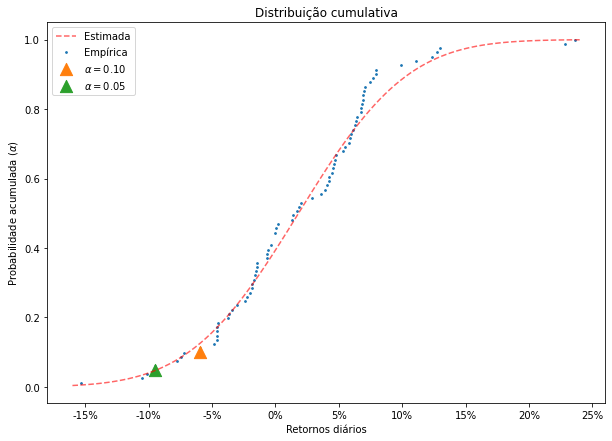

In [519]:
fig,ax = plt.subplots(figsize=(10,7))
ax.set_title('Distribuição cumulativa')

# distribuição empírica
x,f = np.unique(dfQ, return_counts=True)
cdf = f.cumsum()/f.sum()
ax.scatter(x,cdf, s=3, label='Empírica')

# distribuição estimada
y_nor = norm.cdf(np.linspace(r_min, r_max, 100), loc=r_mean, scale=r_std)
ax.plot(np.linspace(r_min, r_max, 100),y_nor, 'r--', alpha=0.6, label='Estimada')

# perda máxima para confiança de 90%
alpha = 0.1
pos90 = np.argwhere(cdf>=alpha)[0][0]
x90 = x[pos90]
ax.scatter(x90, alpha, s=150, marker='^', label=r'$ \alpha=0.10$')


# perda máxima para confiança de 95%
alpha = 0.05
pos95 = np.argwhere(cdf>=alpha)[0][0]
x95 = x[pos95]
ax.scatter(x95, alpha, s=150, marker='^', label=r'$ \alpha=0.05$')
#ax.set_xticks(np.arange(r_min, r_max+0.01, 0.01))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

ax.set_xlabel('Retornos diários')
ax.set_ylabel(r'Probabilidade acumulada ($\alpha$)')
ax.legend()
plt.show()

Com $90\%$ de confiança:

In [520]:
print('VaR: R$ {:.2f}'.format(-x90*M))

VaR: R$ 596.70


Com $95\%$ de confiança:

In [521]:
print('VaR: R$ {:.2f}'.format(-x95*M))

VaR: R$ 951.50


#### Método da Variância

O método da variância estimativa o VaR com base em distribuição normal ajustada com parâmetros $N(\mu, \sigma)$, onde $\mu$ é a média dos retornos e $\sigma$ o desvio padrão amostral. 

Para computarmos a perda máxima % para um dado nível de significância $\alpha$ (confiança igual a $1-\alpha$), utilizamos a função distribuição cumulativa inversa, a qual permite para qual valor da variável aleatória a probabilidade acumulada é $\alpha$.

In [522]:
x90 = norm.ppf(0.10, loc=r_mean, scale=r_std)
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
print('Perda máxima - confiança de 90%: {:.2%}'.format(x90))
print('Perda máxima - confiança de 95%: {:.2%}'.format(x95))

Perda máxima - confiança de 90%: -6.85%
Perda máxima - confiança de 95%: -9.31%


Assim, computamos o VaR:

In [523]:
VaR90 = -x90*M
VaR95 = -x95*M
x95 = norm.ppf(0.05, loc=r_mean, scale=r_std)
print('VaR - confiança de 90%: R$ {:.2f}'.format(VaR90))
print('VaR - confiança de 95%: R$ {:.2f}'.format(VaR95))

VaR - confiança de 90%: R$ 684.78
VaR - confiança de 95%: R$ 930.72


Observamos uma diferença da ordem de quase $R\$90,00$ entre as estimativas do Método Histórico e as estimativas do Método da Variância (para o nível de confiança de $90\%$. Através do histograma e do gráfico da distribuição cumulativa, podemos perceber que essa diferença se dá devido ao fato de que os dados históricos não se ajustam bem à distribuição normal.

Assim, concluimos que o Método da Variância deve ser utilizado com cautela, sendo iportante sempre checar sobre a validade da premissa de distribuição normal dos retornos.

## Conclusões

Neste trabalho...

## Bibliografia

Cabral, M. A. P. **Finanças Matemáticas**: Teoria e Prática. 1 ed. 2020. Disponível em: Disponível em https://sites.google.com/matematica.ufrj.br/mapcabral/livro-finanças-matemática.